### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from src import code_simulator, code, noise

### Parameters

In [2]:
rotation_symmetries = [2, 3, 4]
loss_noise_values = [0.1, 0.05, 0.03, 0.01]
average_photon_numbers = range(1, 4)
number_of_random_code_trials = 80

### Fidelities of Trivial Code

In [3]:
trivial_fidelities = [code_simulator.get_fidelity_of_code_under_noise(code.trivial_code, noise.Noise(2, [("loss", loss_noise_amount)]), False) for loss_noise_amount in loss_noise_values]

### Fidelities of Binomial Code

This will take forever to run on the first time because it needs to calculate a lot of stuff, but subsequent runs should be near instantaneous because all the calculation values are saved to files.

In [4]:
%%time

binomial_fidelities = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), 2))
binomial_photon_numbers = np.zeros((len(rotation_symmetries), len(average_photon_numbers)))
binomial_codes = np.empty((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers))).tolist()
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		for k, average_photon_number in enumerate(average_photon_numbers):
			dimension = (average_photon_number + 2) * rotation_symmetry
			loss_noise = noise.Noise(dimension, [("loss", loss_noise_amount)])
			binomial_code = code.get_binomial_code(rotation_symmetry, average_photon_number, dimension)
			binomial_codes[i][j][k] = binomial_code
			binomial_fidelities[i,j,k,0] = code_simulator.get_fidelity_of_code_under_noise(binomial_code, loss_noise, False)
			binomial_fidelities[i,j,k,1] = code_simulator.get_fidelity_of_code_under_noise(binomial_code, loss_noise, True)
			binomial_photon_numbers[i,k] = qt.expect(qt.num(binomial_code.physical_dimension), 1 / 2 * (binomial_code.zero_encoding * binomial_code.zero_encoding.dag() + binomial_code.one_encoding * binomial_code.one_encoding.dag()))

CPU times: user 95.1 ms, sys: 12.6 ms, total: 108 ms
Wall time: 107 ms


### Fidelities of Cat Code

This will take a bit to run on the first time, but will be near-instantaneous after.

In [5]:
%%time

coherent_state_values = range(1, average_photon_numbers[-1])
cat_fidelities = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(coherent_state_values), 2))
cat_photon_numbers = np.zeros((len(rotation_symmetries), len(coherent_state_values)))
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		for k, coherent_state_value in enumerate(coherent_state_values):
			dimension = max(int(coherent_state_value ** 2 + 2.2 * coherent_state_value) + 1, rotation_symmetry + 1)
			loss_noise = noise.Noise(dimension, [("loss", loss_noise_amount)])
			cat_code = code.get_cat_code(rotation_symmetry, coherent_state_value, 0, dimension)
			cat_fidelities[i,j,k,0] = code_simulator.get_fidelity_of_code_under_noise(cat_code, loss_noise, False)
			cat_fidelities[i,j,k,1] = code_simulator.get_fidelity_of_code_under_noise(cat_code, loss_noise, True)
			cat_photon_numbers[i,k] = qt.expect(qt.num(cat_code.physical_dimension), 1 / 2 * (cat_code.zero_encoding * cat_code.zero_encoding.dag() + cat_code.one_encoding * cat_code.one_encoding.dag()))

CPU times: user 38.5 ms, sys: 4.81 ms, total: 43.3 ms
Wall time: 42.8 ms


### Fidelities of Haar Random Codes

This will probably always take a bit.

In [6]:
%%time

random_fidelities = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), number_of_random_code_trials, 2))
random_photon_numbers = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), number_of_random_code_trials))
random_codes = np.empty((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), number_of_random_code_trials)).tolist()
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		for k, average_photon_number in enumerate(average_photon_numbers):
			for l in range(number_of_random_code_trials):
				dimension = (average_photon_number + 2) * rotation_symmetry
				loss_noise = noise.Noise(dimension, [("loss", loss_noise_amount)])
				random_code = code.make_projected_haar_random_code(rotation_symmetry, average_photon_number, dimension)
				random_codes[i][j][k][l] = random_code
				random_fidelities[i,j,k,l,0] = code_simulator.get_fidelity_of_code_under_noise(random_code, loss_noise, False)
				random_fidelities[i,j,k,l,1] = code_simulator.get_fidelity_of_code_under_noise(random_code, loss_noise, True)
				random_photon_numbers[i,j,k,l] = qt.expect(qt.num(random_code.physical_dimension), 1 / 2 * (random_code.zero_encoding * random_code.zero_encoding.dag() + random_code.one_encoding * random_code.one_encoding.dag()))

CPU times: user 10min 10s, sys: 6min 36s, total: 16min 46s
Wall time: 5min 21s


### Plots of Error Rates vs. Average Number

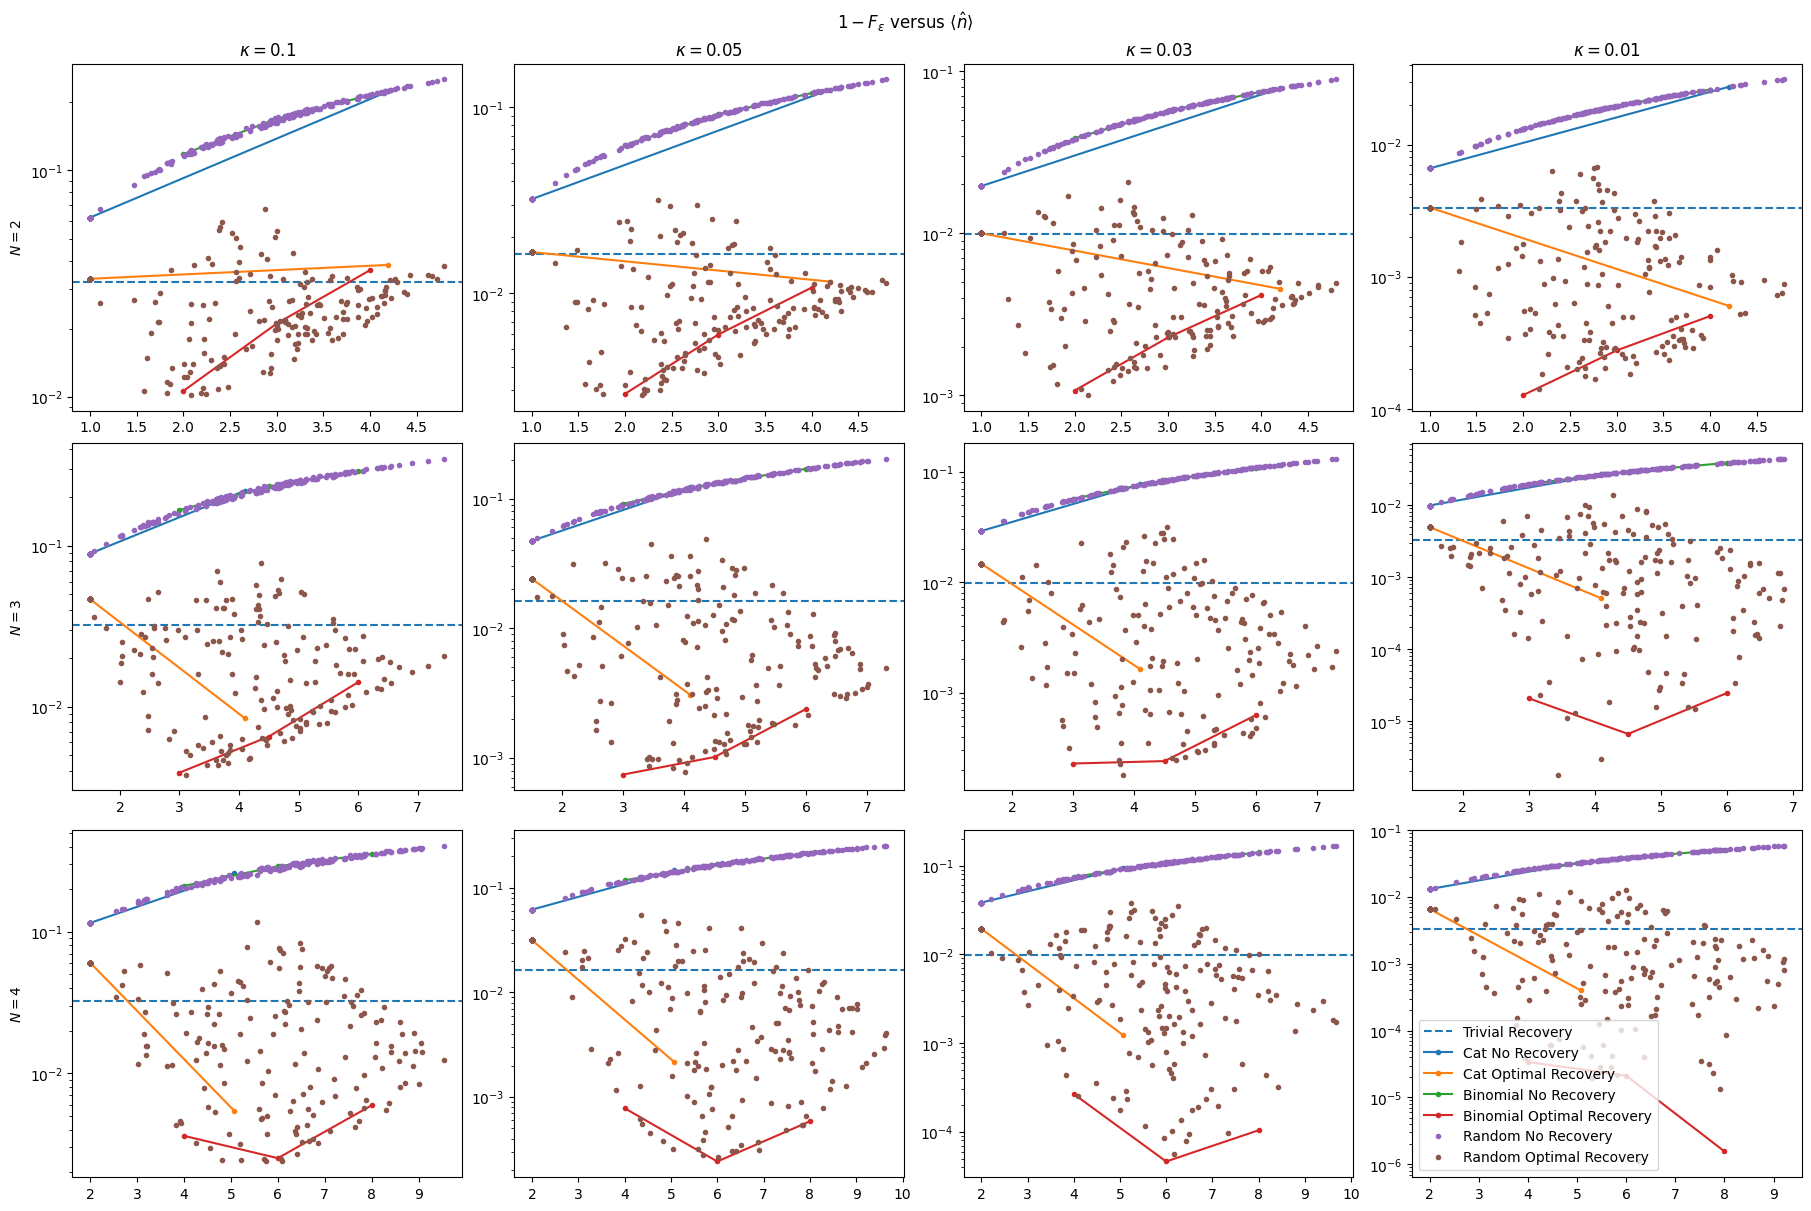

In [7]:
fig, axs = plt.subplots(len(rotation_symmetries), len(loss_noise_values), figsize=(18, 12), constrained_layout=True)
fig.suptitle(r"$1 - F_\epsilon$ versus $\langle\hat{n}\rangle$")
for i, rotation_symmetry in enumerate(rotation_symmetries):
	axs[i,0].set_ylabel(f"$N={rotation_symmetry}$")
for i, loss_noise_amount in enumerate(loss_noise_values):
	axs[0,i].set_title(f"$\\kappa={loss_noise_amount}$")

largest_x_limits = [float("infinity"), -float("infinity")]
largest_y_limits = [float("infinity"), -float("infinity")]
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		axs[i,j].axhline(1 - trivial_fidelities[j], linestyle="--", label="Trivial Recovery")
		axs[i,j].semilogy(cat_photon_numbers[i], 1 - cat_fidelities[i,j,:,0], ".-", label="Cat No Recovery")
		axs[i,j].semilogy(cat_photon_numbers[i], 1 - cat_fidelities[i,j,:,1], ".-", label="Cat Optimal Recovery")
		axs[i,j].semilogy(binomial_photon_numbers[i], 1 - binomial_fidelities[i,j,:,0], ".-", label="Binomial No Recovery")
		axs[i,j].semilogy(binomial_photon_numbers[i], 1 - binomial_fidelities[i,j,:,1], ".-", label="Binomial Optimal Recovery")
		axs[i,j].semilogy(random_photon_numbers[i,j,:,:].flatten(), 1 - random_fidelities[i,j,:,:,0].flatten(), ".", label="Random No Recovery")
		axs[i,j].semilogy(random_photon_numbers[i,j,:,:].flatten(), 1 - random_fidelities[i,j,:,:,1].flatten(), ".", label="Random Optimal Recovery")
		xlimits = axs[i,j].get_xlim()
		ylimits = axs[i,j].get_ylim()
		if xlimits[0] < largest_x_limits[0]:
			largest_x_limits[0] = xlimits[0]
		if xlimits[1] > largest_x_limits[1]:
			largest_x_limits[1] = xlimits[1]
		if ylimits[0] < largest_y_limits[0]:
			largest_y_limits[0] = ylimits[0]
		if ylimits[1] > largest_y_limits[1]:
			largest_y_limits[1] = ylimits[1]

axs[-1,-1].legend()
plt.show()

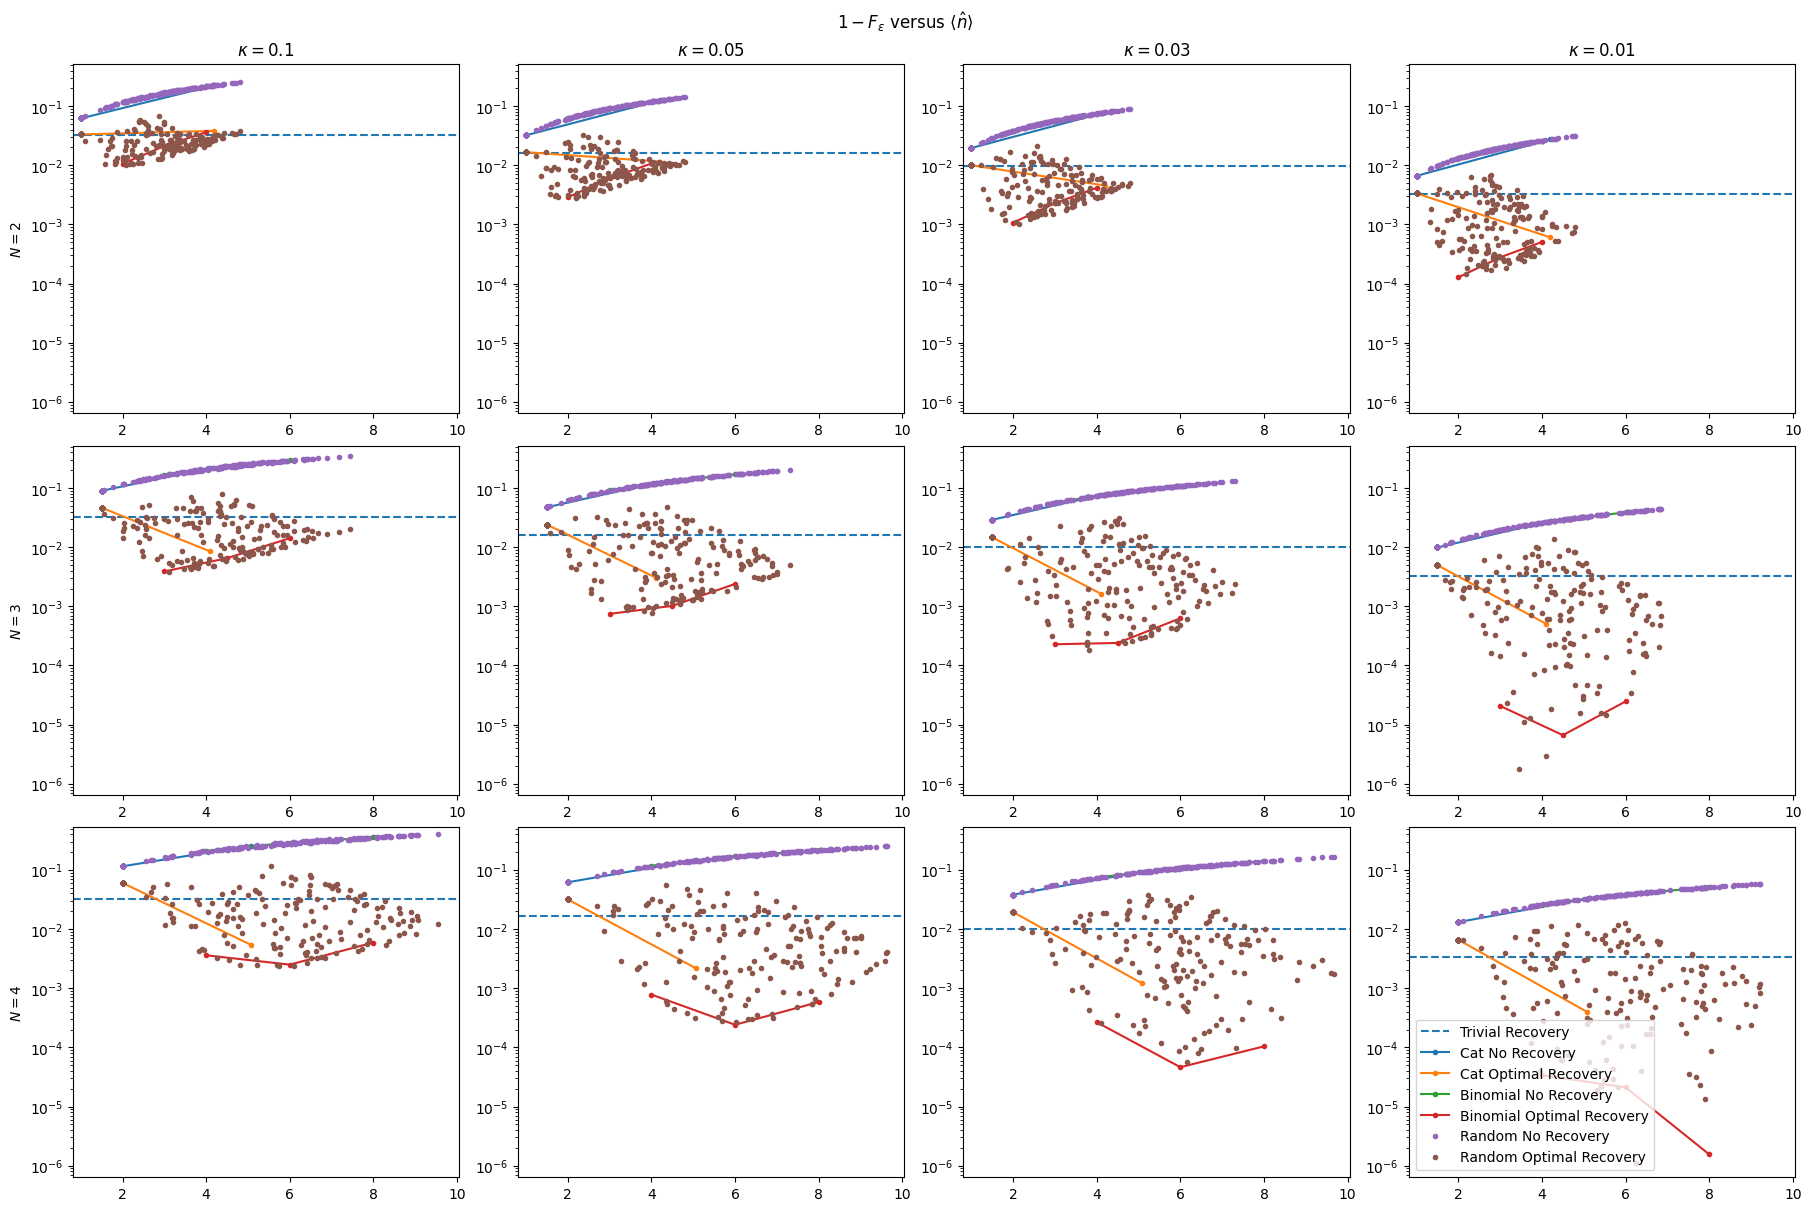

In [8]:
fig, axs = plt.subplots(len(rotation_symmetries), len(loss_noise_values), figsize=(18, 12), constrained_layout=True)
fig.suptitle(r"$1 - F_\epsilon$ versus $\langle\hat{n}\rangle$")
for i, rotation_symmetry in enumerate(rotation_symmetries):
	axs[i,0].set_ylabel(f"$N={rotation_symmetry}$")
for i, loss_noise_amount in enumerate(loss_noise_values):
	axs[0,i].set_title(f"$\\kappa={loss_noise_amount}$")

for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		axs[i,j].set_xlim(largest_x_limits)
		axs[i,j].set_ylim(largest_y_limits)
		axs[i,j].axhline(1 - trivial_fidelities[j], linestyle="--", label="Trivial Recovery")
		axs[i,j].semilogy(cat_photon_numbers[i], 1 - cat_fidelities[i,j,:,0], ".-", label="Cat No Recovery")
		axs[i,j].semilogy(cat_photon_numbers[i], 1 - cat_fidelities[i,j,:,1], ".-", label="Cat Optimal Recovery")
		axs[i,j].semilogy(binomial_photon_numbers[i], 1 - binomial_fidelities[i,j,:,0], ".-", label="Binomial No Recovery")
		axs[i,j].semilogy(binomial_photon_numbers[i], 1 - binomial_fidelities[i,j,:,1], ".-", label="Binomial Optimal Recovery")
		axs[i,j].semilogy(random_photon_numbers[i,j,:,:].flatten(), 1 - random_fidelities[i,j,:,:,0].flatten(), ".", label="Random No Recovery")
		axs[i,j].semilogy(random_photon_numbers[i,j,:,:].flatten(), 1 - random_fidelities[i,j,:,:,1].flatten(), ".", label="Random Optimal Recovery")

axs[-1,-1].legend()
plt.show()

### Analysis of Optimal Random Codes When Compared Against Optimal Binomial Codes

At $N = 2$ and $\kappa = 0.1$, a random code beat the best binomial code.
Lowest random code error: 0.01017188741232733;	Lowest binomial code error: 0.010617828180579658;	Difference: 0.00044594076825232865
Code similarities: (0.1277893109997955, 0.9848119434069653, 0.21383593838900017, 0.21383593838900017)


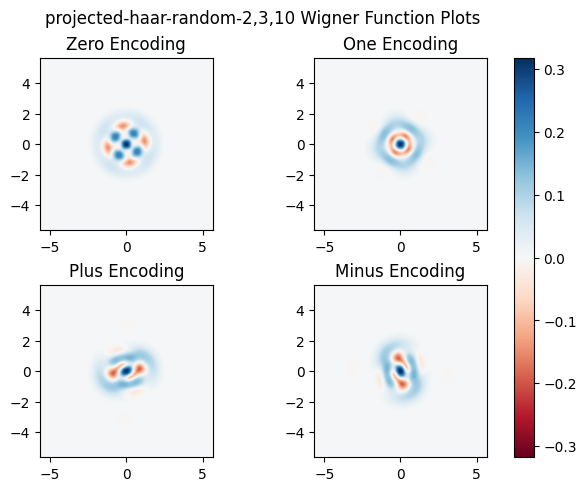

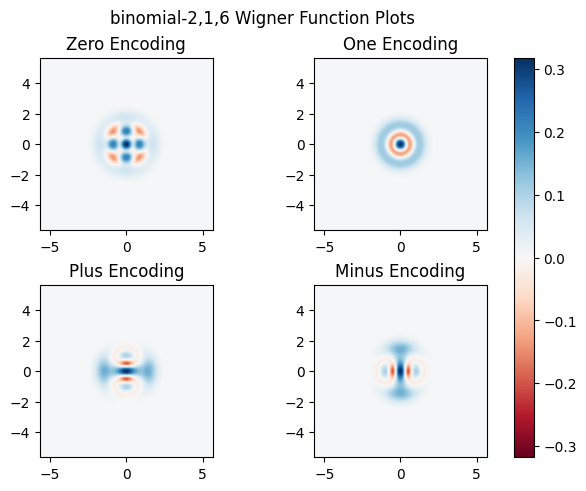

At $N = 2$ and $\kappa = 0.05$, a random code beat the best binomial code.
Lowest random code error: 0.0028302515994581556;	Lowest binomial code error: 0.002877823122887535;	Difference: 4.7571523429379425e-05
Code similarities: (0.8489210647850352, 0.9633345309392536, 0.5529668655055001, 0.5529668655055001)


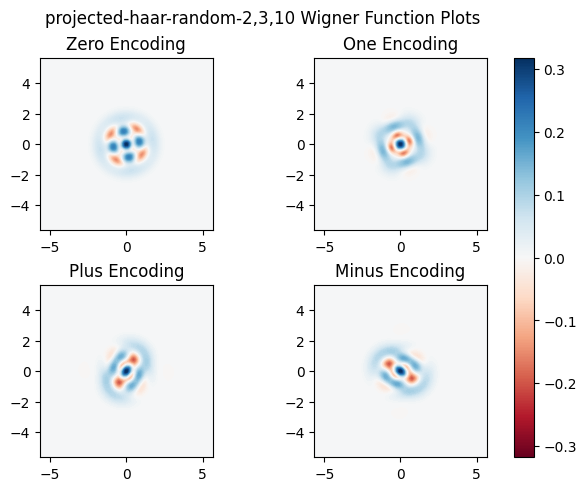

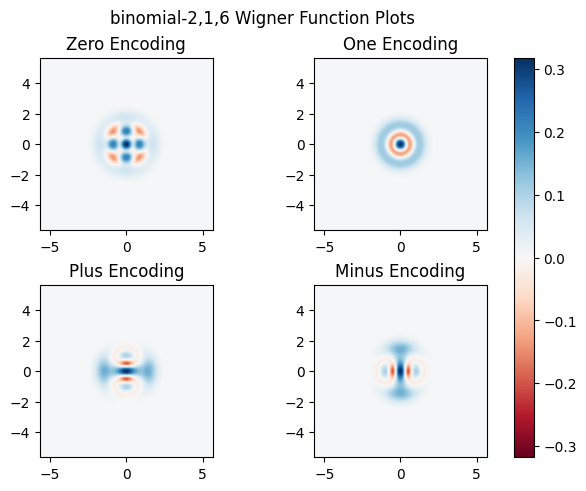

At $N = 2$ and $\kappa = 0.03$, a random code beat the best binomial code.
Lowest random code error: 0.0010023226034953092;	Lowest binomial code error: 0.0010703987301918794;	Difference: 6.807612669657015e-05
Code similarities: (0.43339504161916126, 0.9473236632904585, 0.05056252739570623, 0.05056252739570623)


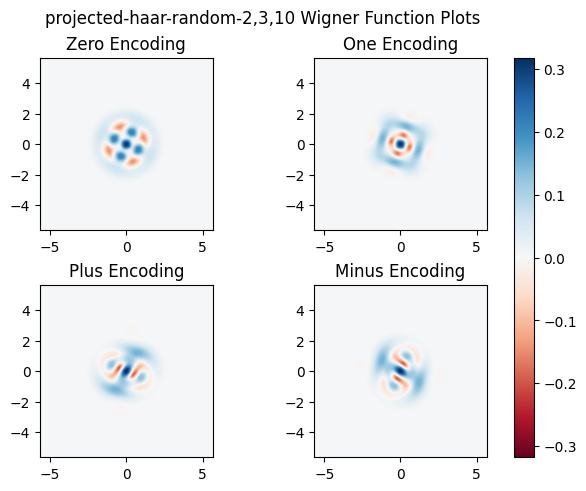

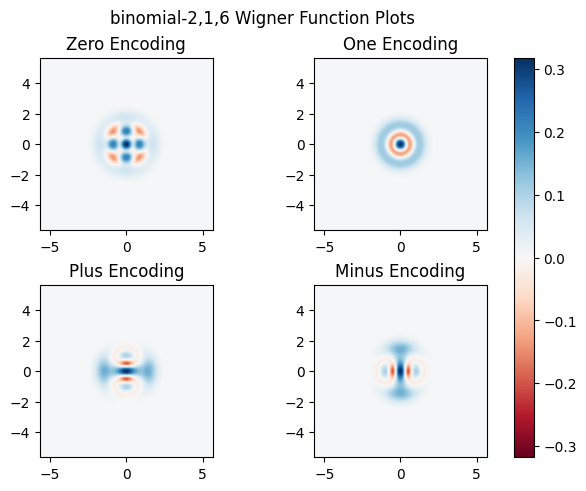

At $N = 3$ and $\kappa = 0.1$, a random code beat the best binomial code.
Lowest random code error: 0.003788385347738399;	Lowest binomial code error: 0.003890784510335088;	Difference: 0.00010239916259668913
Code similarities: (0.1665408159192199, 0.975542970270155, 0.33395919185389533, 0.33395919185389533)


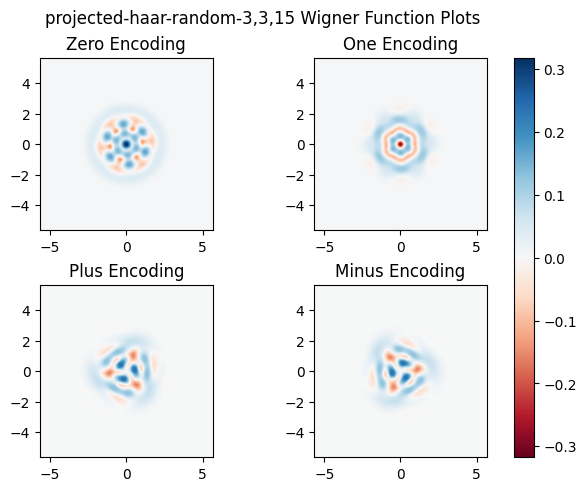

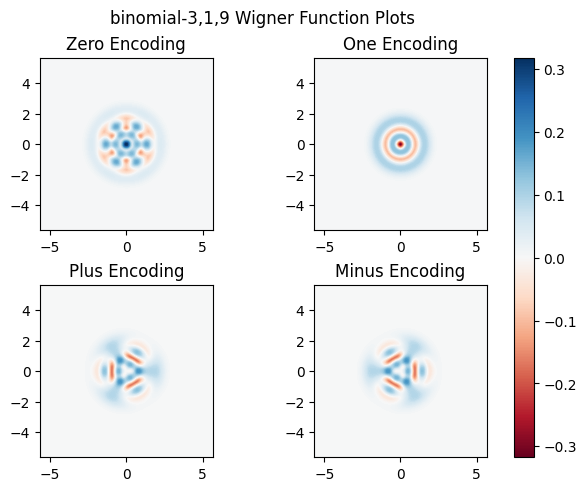

At $N = 3$ and $\kappa = 0.03$, a random code beat the best binomial code.
Lowest random code error: 0.00018165788814317185;	Lowest binomial code error: 0.0002285598787045151;	Difference: 4.6901990561343254e-05
Code similarities: (0.8027895032090591, 0.8512445834805781, 0.8211141542661764, 0.8211141542661764)


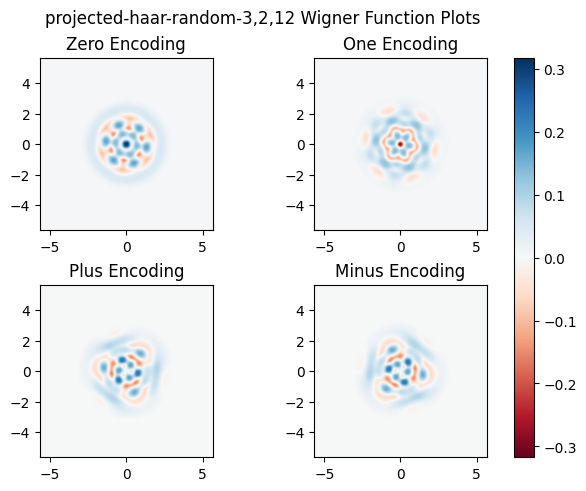

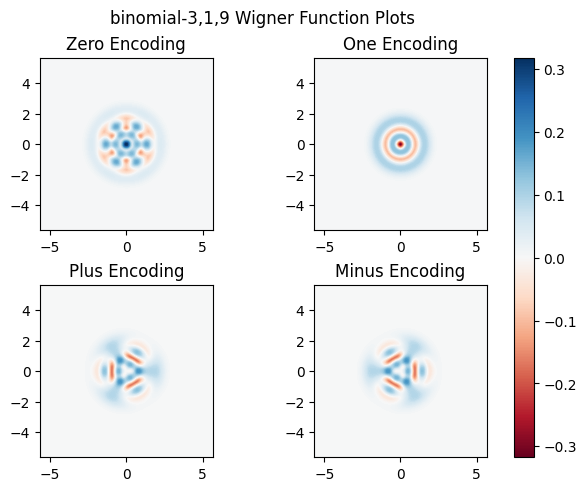

At $N = 3$ and $\kappa = 0.01$, a random code beat the best binomial code.
Lowest random code error: 1.8138657167376948e-06;	Lowest binomial code error: 6.640846514804899e-06;	Difference: 4.826980798067204e-06
Code similarities: (0.10489888960001661, 0.6353087854646413, 0.10371397322202919, 0.10371397322202919)


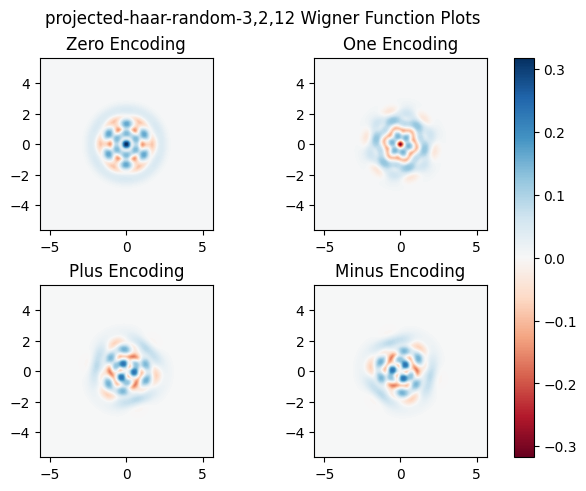

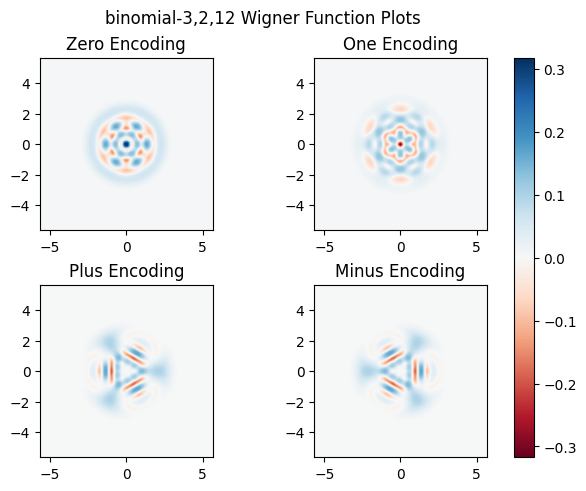

At $N = 4$ and $\kappa = 0.1$, a random code beat the best binomial code.
Lowest random code error: 0.0023768944119693103;	Lowest binomial code error: 0.0025088146910041687;	Difference: 0.00013192027903485837
Code similarities: (0.7502957530651182, 0.8987116000724892, 0.8225027657925486, 0.8225027657925486)


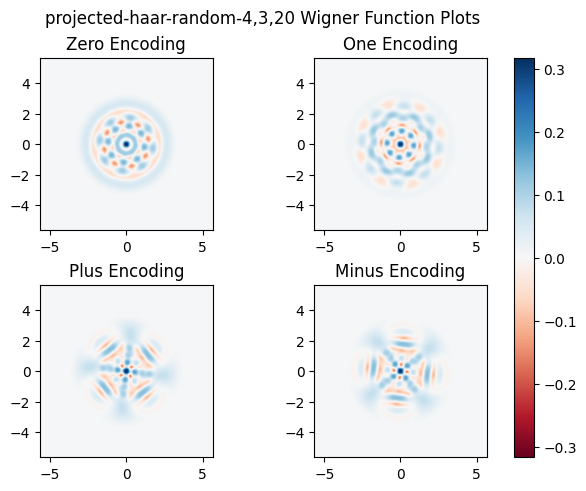

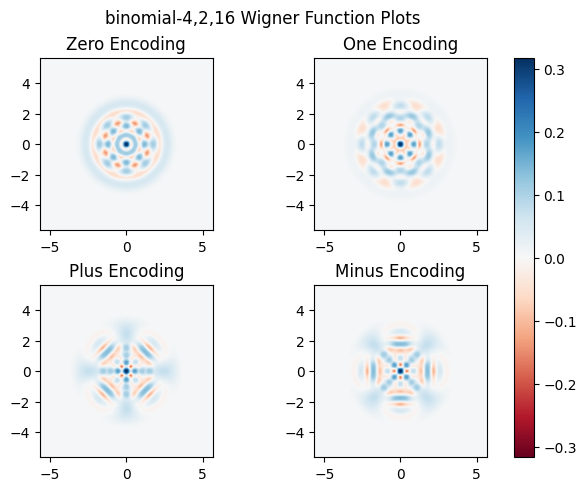

At $N = 4$ and $\kappa = 0.01$, a random code beat the best binomial code.
Lowest random code error: 1.0988443833737094e-06;	Lowest binomial code error: 1.5530330493840339e-06;	Difference: 4.541886660103245e-07
Code similarities: (0.8532213578229894, 0.9419082611623226, 0.41554029344200905, 0.41554029344200905)


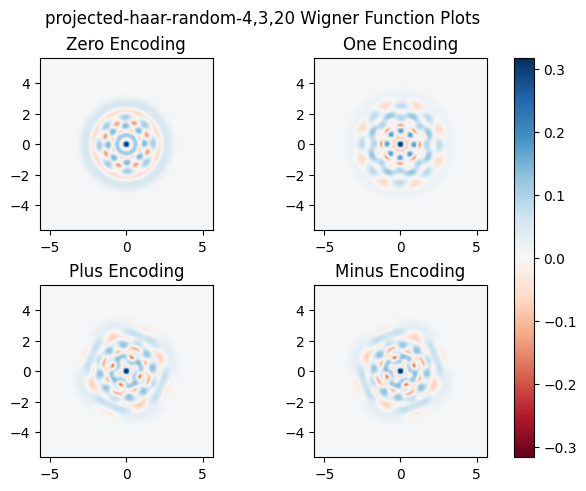

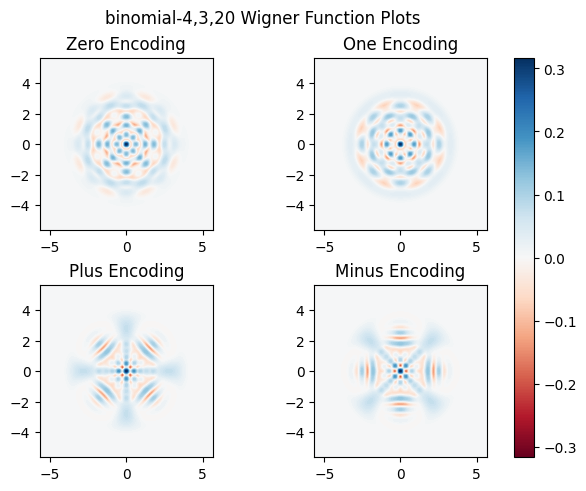

In [9]:
flattened_random_fidelities = random_fidelities.reshape((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers) * number_of_random_code_trials * 2))
flattened_binomial_fidelities = binomial_fidelities.reshape((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers) * 2))
best_random_fidelities_in_each_region = np.amax(flattened_random_fidelities, 2)
best_binomial_fidelities_in_each_region = np.amax(flattened_binomial_fidelities, 2)

for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		random_fidelity_in_region = best_random_fidelities_in_each_region[i,j]
		binomial_fidelity_in_region = best_binomial_fidelities_in_each_region[i,j]
		if random_fidelity_in_region < binomial_fidelity_in_region:
			continue
		random_code_parameter_indices = np.where(random_fidelities[i,j] == random_fidelity_in_region)
		random_code = random_codes[i][j][int(random_code_parameter_indices[0])][int(random_code_parameter_indices[1])]
		code.serialize_code(random_code)
		binomial_code_parameter_indices = np.where(binomial_fidelities[i,j] == binomial_fidelity_in_region)
		binomial_code = binomial_codes[i][j][int(binomial_code_parameter_indices[0])]
		print(f"At $N = {rotation_symmetry}$ and $\\kappa = {loss_noise_amount}$, a random code beat the best binomial code.")
		print(f"Lowest random code error: {1 - random_fidelity_in_region};\tLowest binomial code error: {1 - binomial_fidelity_in_region};\tDifference: {random_fidelity_in_region - binomial_fidelity_in_region}")
		print(f"Code similarities: {code_simulator.compute_code_similarities(random_code, binomial_code)}")
		code_simulator.make_wigner_plots_for(random_code)
		plt.show()
		code_simulator.make_wigner_plots_for(binomial_code)
		plt.show()

### Plot Generation

#### Everything Plot

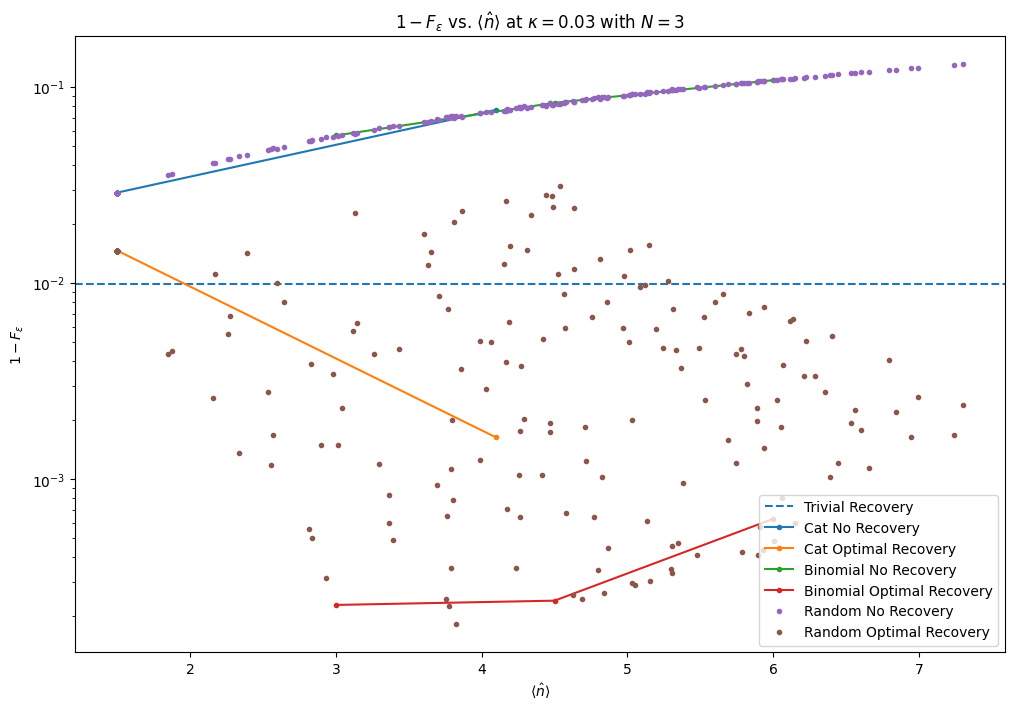

In [10]:
specific_graph_indices = (1, 2)
figure_size = (12, 8)
fig, axs = plt.subplots(figsize=figure_size)
axs.axhline(1 - trivial_fidelities[specific_graph_indices[1]], linestyle="--", label="Trivial Recovery")
axs.semilogy(cat_photon_numbers[specific_graph_indices[0]], 1 - cat_fidelities[specific_graph_indices[0],specific_graph_indices[1],:,0], ".-", label="Cat No Recovery")
axs.semilogy(cat_photon_numbers[specific_graph_indices[0]], 1 - cat_fidelities[specific_graph_indices[0],specific_graph_indices[1],:,1], ".-", label="Cat Optimal Recovery")
axs.semilogy(binomial_photon_numbers[specific_graph_indices[0]], 1 - binomial_fidelities[specific_graph_indices[0],specific_graph_indices[1],:,0], ".-", label="Binomial No Recovery")
axs.semilogy(binomial_photon_numbers[specific_graph_indices[0]], 1 - binomial_fidelities[specific_graph_indices[0],specific_graph_indices[1],:,1], ".-", label="Binomial Optimal Recovery")
axs.semilogy(random_photon_numbers[specific_graph_indices[0],specific_graph_indices[1],:,:].flatten(), 1 - random_fidelities[specific_graph_indices[0],specific_graph_indices[1],:,:,0].flatten(), ".", label="Random No Recovery")
axs.semilogy(random_photon_numbers[specific_graph_indices[0],specific_graph_indices[1],:,:].flatten(), 1 - random_fidelities[specific_graph_indices[0],specific_graph_indices[1],:,:,1].flatten(), ".", label="Random Optimal Recovery")
axs.set_xlabel(r"$\langle\hat{n}\rangle$")
axs.set_ylabel(r"$1 - F_\epsilon$")
axs.set_title(r"$1 - F_\epsilon$ vs. $\langle\hat{n}\rangle$ at $\kappa = " + str(loss_noise_values[specific_graph_indices[1]]) + r"$ with $N = " + str(rotation_symmetries[specific_graph_indices[0]]) + r"$")
axs.legend(loc="lower right")
plt.show()

specific_graph_limits = (axs.get_xlim(), axs.get_ylim())

#### Just the Trivial Line

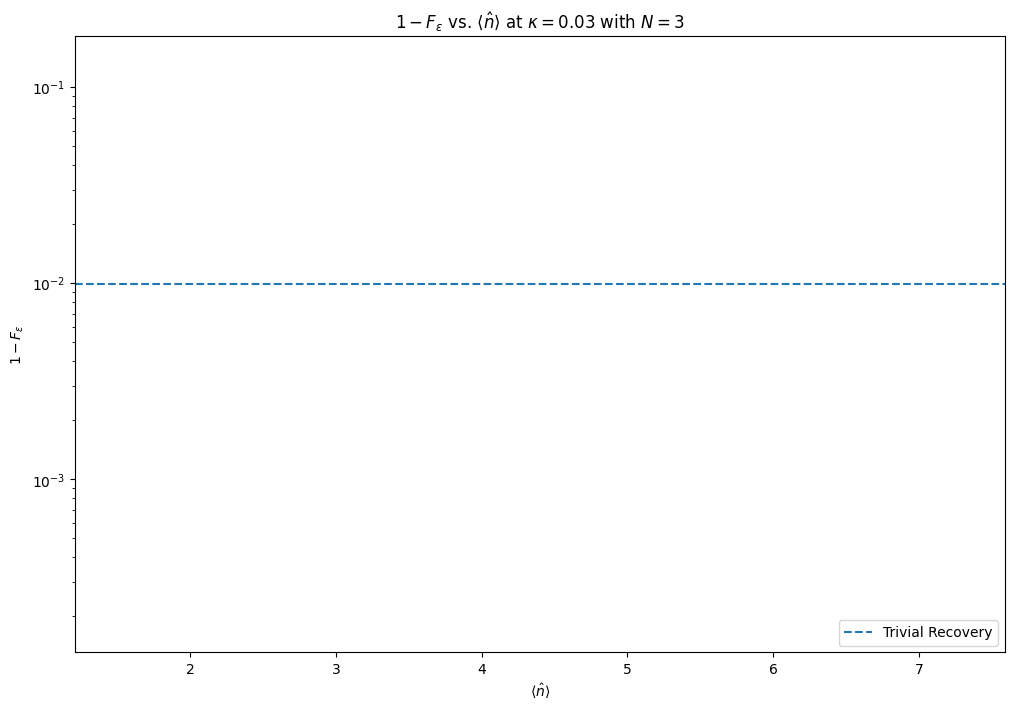

In [11]:
fig, axs = plt.subplots(figsize=figure_size)
axs.axhline(1 - trivial_fidelities[specific_graph_indices[1]], linestyle="--", label="Trivial Recovery")
axs.set_xlabel(r"$\langle\hat{n}\rangle$")
axs.set_ylabel(r"$1 - F_\epsilon$")
axs.set_title(r"$1 - F_\epsilon$ vs. $\langle\hat{n}\rangle$ at $\kappa = " + str(loss_noise_values[specific_graph_indices[1]]) + r"$ with $N = " + str(rotation_symmetries[specific_graph_indices[0]]) + r"$")
axs.legend(loc="lower right")
axs.set_xlim(*specific_graph_limits[0])
axs.set_yscale("log")
axs.set_ylim(*specific_graph_limits[1])
plt.show()

#### Add Cat Code

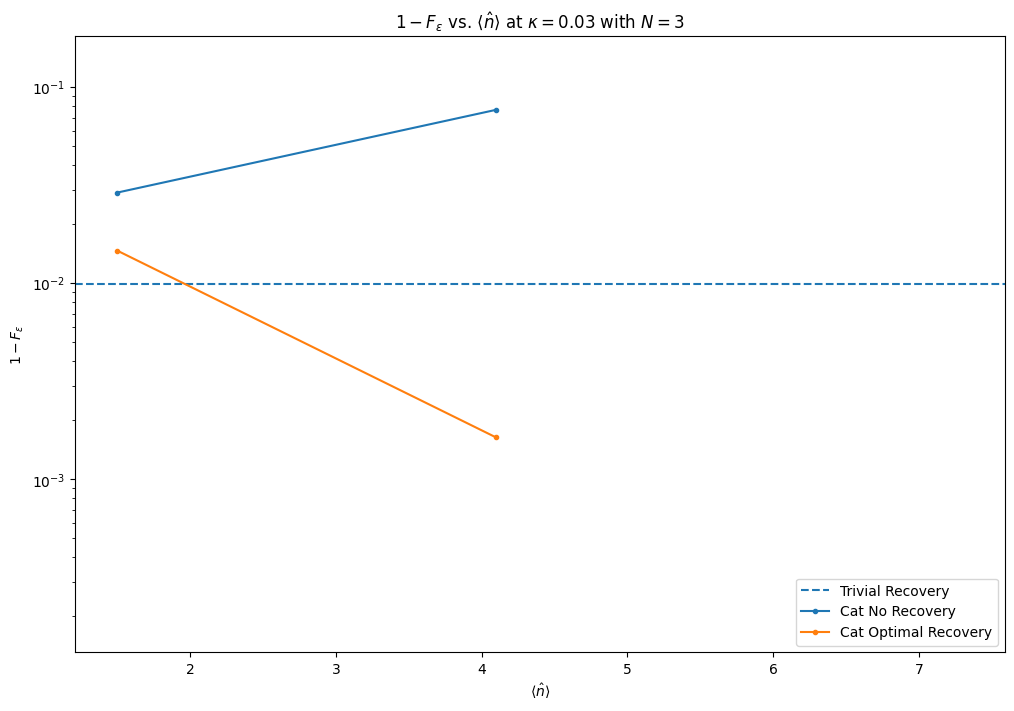

In [12]:
fig, axs = plt.subplots(figsize=figure_size)
axs.axhline(1 - trivial_fidelities[specific_graph_indices[1]], linestyle="--", label="Trivial Recovery")
axs.semilogy(cat_photon_numbers[specific_graph_indices[0]], 1 - cat_fidelities[specific_graph_indices[0],specific_graph_indices[1],:,0], ".-", label="Cat No Recovery")
axs.semilogy(cat_photon_numbers[specific_graph_indices[0]], 1 - cat_fidelities[specific_graph_indices[0],specific_graph_indices[1],:,1], ".-", label="Cat Optimal Recovery")
axs.set_xlabel(r"$\langle\hat{n}\rangle$")
axs.set_ylabel(r"$1 - F_\epsilon$")
axs.set_title(r"$1 - F_\epsilon$ vs. $\langle\hat{n}\rangle$ at $\kappa = " + str(loss_noise_values[specific_graph_indices[1]]) + r"$ with $N = " + str(rotation_symmetries[specific_graph_indices[0]]) + r"$")
axs.legend(loc="lower right")
axs.set_xlim(*specific_graph_limits[0])
axs.set_yscale("log")
axs.set_ylim(*specific_graph_limits[1])
plt.show()

#### Add Binomial Code

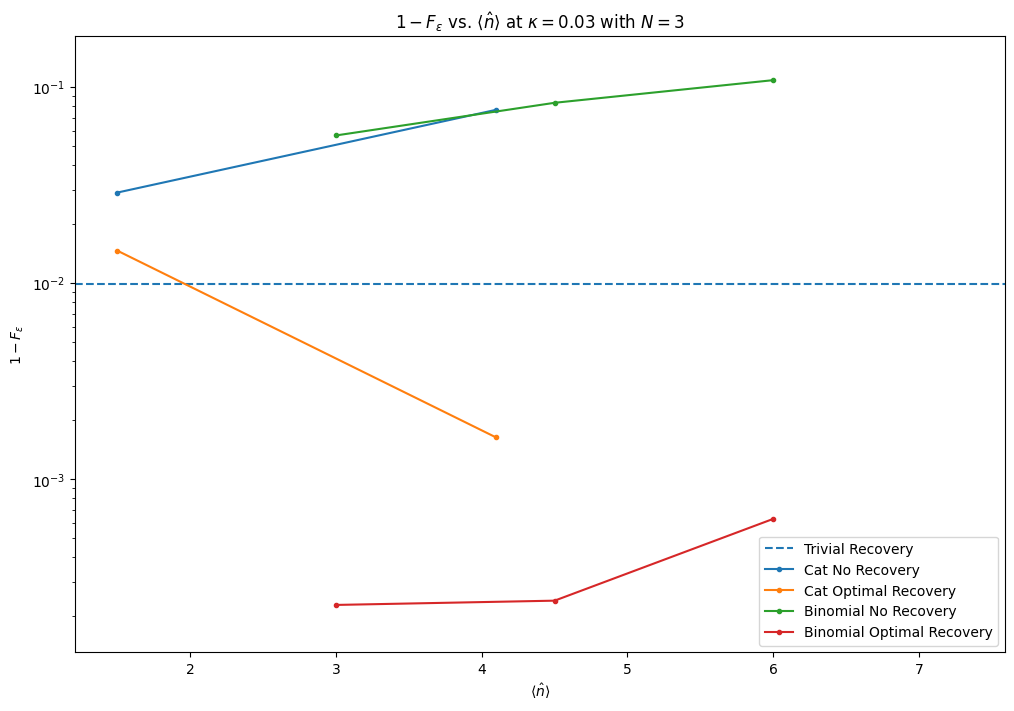

In [13]:
fig, axs = plt.subplots(figsize=figure_size)
axs.axhline(1 - trivial_fidelities[specific_graph_indices[1]], linestyle="--", label="Trivial Recovery")
axs.semilogy(cat_photon_numbers[specific_graph_indices[0]], 1 - cat_fidelities[specific_graph_indices[0],specific_graph_indices[1],:,0], ".-", label="Cat No Recovery")
axs.semilogy(cat_photon_numbers[specific_graph_indices[0]], 1 - cat_fidelities[specific_graph_indices[0],specific_graph_indices[1],:,1], ".-", label="Cat Optimal Recovery")
axs.semilogy(binomial_photon_numbers[specific_graph_indices[0]], 1 - binomial_fidelities[specific_graph_indices[0],specific_graph_indices[1],:,0], ".-", label="Binomial No Recovery")
axs.semilogy(binomial_photon_numbers[specific_graph_indices[0]], 1 - binomial_fidelities[specific_graph_indices[0],specific_graph_indices[1],:,1], ".-", label="Binomial Optimal Recovery")
axs.set_xlabel(r"$\langle\hat{n}\rangle$")
axs.set_ylabel(r"$1 - F_\epsilon$")
axs.set_title(r"$1 - F_\epsilon$ vs. $\langle\hat{n}\rangle$ at $\kappa = " + str(loss_noise_values[specific_graph_indices[1]]) + r"$ with $N = " + str(rotation_symmetries[specific_graph_indices[0]]) + r"$")
axs.legend(loc="lower right")
axs.set_xlim(*specific_graph_limits[0])
axs.set_yscale("log")
axs.set_ylim(*specific_graph_limits[1])
plt.show()